## 目标检测

不仅确定图像的类别，还确定其具体的位置的任务。我们称其为目标检测(`object detection`)或者称之为目标识别(`object recognition`)。

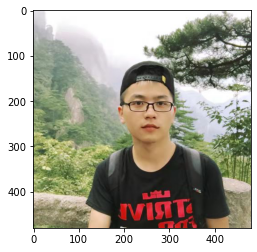

In [1]:
import torch

from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('../images/tinyzqh.jpg')  # 读取图片
plt.imshow(img)  # imshow展示图片。

## 边界框

目标检测任务中，我们常使用边界框(`bounding box`)来描述对象的空间位置。目标检测是识别图片中所有的物品，并对应其位置。

1. 边界框是矩形，由矩形左上角以及右下角的$x$和$y$坐标决定。
2. 另一种常用的边界框表示方法是边界框中心的$(x, y)$轴坐标以及框的宽度和高度。

两种表示方法之间可以相互转换，定义两种表示方法：

1. `box_corner_to_center`从两角表示法转换为中心宽度表示法。
2. `box_center_to_corner`从中心宽度表示法转换为两角表示法。


In [2]:
def box_corner_to_center(boxes):
    """
    # 从(左上，右下)转变为(中间, 宽度，高度)。
    """
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    
    cx = (x1 + x2) / 2  # 中间的x。
    cy = (y1 + y2) / 2  # 中间的y。
    
    w = x2 - x1
    h = y2 - y1
    
    return torch.stack((cx, cy, w, h), axis=1)

In [3]:
def box_center_to_corner(boxes):
    """
    # 从(中间, 宽度，高度)转变为(左上，右下)。
    """
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    
    return torch.stack((x1, y1, x2, y2), axis=1)

依据坐标信息可以画一个框。

一般在图像中，左上角是图像的原点，往右方向是$x$轴正方向，往下方向是$y$轴正方向。

In [4]:
# x1, y1 ; x2, y2。
bbox1, bbox2 = [160.0, 105.0, 358.0, 316.0], [270.0, 12.0, 465.0, 193.0]
boxes = torch.tensor((bbox1, bbox2))
boxes

tensor([[160., 105., 358., 316.],
        [270.,  12., 465., 193.]])

In [5]:
# 将坐标从角转换为中心，再转换为角，应该是一样的。以此来验证代码没有写错。
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [6]:
import matplotlib.pyplot as plt
def bbox_to_rect(bbox, color):
    """
    给定的bbox是四个点的坐标: (x1, y1), (x2, y2)。
    """
    return plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
                            fill=False, edgecolor=color, linewidth=2)

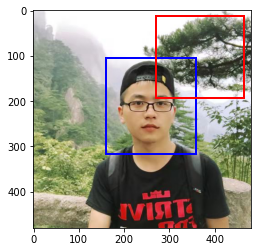

In [7]:
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(bbox1, 'blue'))
fig.axes.add_patch(bbox_to_rect(bbox2, 'red'))

## 锚框

目标检测算法通常会在图像中采样大量的区域，然后判断这些区域中是否包含我们感兴趣的目标，并调整区域边界从而更准确地预测目标的真实边界框(`ground-truth bounding box`)。

不同的模型使用的区域采样方法可能不同，我们介绍其中的一种:

以每个像素为中心，生成多个缩放比和高宽比的不同边界框。这些边界框被称为锚框(`anchor box`)。


一大类的目标检测算法是基于锚框的，也有不是基于锚框的，但是主流的算法还是基于锚框的。锚框说的是算法提出多个框，然后与真实的框进行对比。



### 生成多个锚框

假设输入图像的高度为$h$，宽度为$w$。我们以图像的每个像素为中心，生成不同形状的锚框:

缩放比为$s \in (0, 1]$, 宽高比为$r > 0$。那么锚框的宽度和高度分别是$w \times s\times \sqrt{r}$和$h \times s \frac{1}{\sqrt{r}}$。当中心位置给定时，已知宽和高的锚框是确定的。

其中$s$是对宽和高的单独缩放，总面积应该是缩放到$w \times h \times s^{2}$



要生成多个不同形状的锚框，我们需要设置许多缩放比(`scale`)取值$s_{1}, \cdots, s_{n}$，和许多宽高比(`aspect ratio`)取值$r_{1}, \cdots, r_{m}$。当使用这些比例和长宽比的所有组合以每个像素为中心时，输入图像将总共有$w \times h \times n \times m$个锚框。

尽管这些锚框可能会覆盖所有真实边界框，但计算复杂性很容易过高。在实践中，我们只考虑包含$s_{1}$或$r_{1}$的组合。

$$
\left(s_{1}, r_{1}\right),\left(s_{1}, r_{2}\right), \ldots,\left(s_{1}, r_{m}\right),\left(s_{2}, r_{1}\right),\left(s_{3}, r_{1}\right), \ldots,\left(s_{n}, r_{1}\right)
$$

这样，以同一像素为中心的锚框的数量是$n + m - 1$。对于整个输入图像，我们将共生成$w \times h \times (n + m -1)$个框。

In [8]:
def multibox_prior(data, sizes, ratios):
    """
    生成以每个像素为中心，具有不同形状的锚框
    data: 输入数据。
    size: 缩放比。
    ratios: 高宽比。
    """
    in_height, in_width = data.shape[-2:]  # 最后两个维度获取数据的高和宽。
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    
    boxes_per_pixel = (num_sizes + num_ratios -1)  # 每个像素具有的boxes数量。
    
    size_tensor = torch.tensor(sizes, device=device)  # 将数据转换为Tensor类型。
    ratio_tensor = torch.tensor(ratios, device=device)
    
    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的高为1，且宽为1，所以，我们选择偏移我们的中心0.5。
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height # 在y轴上缩放步长。
    steps_w = 1.0 / in_width  # 在x轴上缩放步长
    
    # 生成锚框的所有中心点。
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    
    # 生成只包含s1和r1的锚框。由于ratio为真实比例，因此当ratio=1时，应该满足w=h，故要乘以 in_height / in_width。
    # 也就是w与h的比例，要与原始图像height与width的比例挂钩。
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]), 
                   sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1: ])))
    
    # 每一行对应一个锚框的左上角偏差和右下角偏差。除以2来获得半高和半宽。
    # 重复in_height * in_width多次，是因为有这么多个像素点。
    anchor_mainpulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
    
    # 每个中心点都将有“boxes_per_pixel”个锚框，所以将其重复这么多次。
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], 
                           dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_mainpulations
    return output.unsqueeze(0)

In [9]:
img = plt.imread('../images/tinyzqh.jpg')  # 读取图片
h, w = img.shape[:2]
print(h, w)
X = torch.rand(size=(1, 3, h, w))  # 一个batch, 3个通道，图片高度为h，宽度为w。
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

480 480


torch.Size([1, 1152000, 4])

之后，我们将这个锚框变量`Y`的`shape`做个变换，更改为: (图像高度，图像宽度，以同一像素为中心的锚框的数量，4)。这样的形状。

然后以访问(250, 250)这个像素点为中心的第一个锚框。它有四个元素：锚框左上角的$(x, y)$轴坐标和右下角的$(x, y)$坐标。

因为两个轴的坐标分别是除以图像的宽度和高度的，所以其值介于0和1之间。

In [10]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.1469, 0.1469, 0.8969, 0.8969])

为了显示图像中，以某个像素为中心的所有锚框，我们定义了如下的`show_bboxes`函数来在图像上绘制多个边界框。

In [11]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """
    # 显示所有边框
    """
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]  # 选中给定的颜色
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        
        if labels and len(labels) > i:  # 如果标签存在
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center', ha='center',
                      fontsize=9, color=text_color, bbox=dict(facecolor=color, lw=0))

变量`boxes`中$x$轴和$y$轴的坐标值已分别除以图像的宽度和高度。绘制锚框时，我们需要恢复它原始的坐标值。因此，我们定义了变量`bbox_scale`。现在，我们就可以绘制出所有以$(250, 250)$为中心的锚框了。

tensor([480, 480, 480, 480])


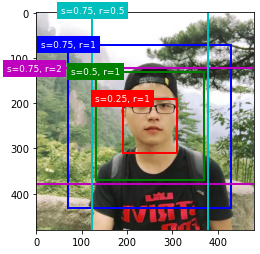

In [12]:
bbox_scale = torch.tensor((w, h, w, h))
print(bbox_scale)
fig = plt.imshow(img)  # 读取图片
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale, 
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5'])

### IoU-交并比

IoU用来计算两个框之间的相似度。0表示无重叠，1表示重合。

给定两个集合$A$和$B$，交并比可以表示为:

$$
J(A, B)=\frac{|A \cap B|}{|A \cup B|}
$$

我们将使用交并比来衡量锚框和真实边界框之间，以及不同锚框之间的相似度。给定两个锚框或边界框的列表，以下`box_iou`函数将在这两个列表中计算它们成对的交并比。

In [13]:
def box_iou(boxes1, boxes2):
    """
    # 计算两个锚框或者边界框列表中成对的交并比。
    """
    # 定义一个函数，输入一个boxes，输出这个boxes对应的面积。
    box_area = lambda boxes : ((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]))
    
    # boxes1: (boxes1的数量, 4)
    # boxes2: (boxes2的数量, 4)
    
    
    areas1 = box_area(boxes1)  # 算出矩形框1的面积。
    areas2 = box_area(boxes2)  # 算出矩形框2的面积。
    
    # 生成的数量是(boxes1的数量, boxes2的数量, 2)。
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # 取前两列，也就是x1和y1。但是是两两之间算。
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # 取后两列，也就是x2和y2。
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)  # 两者相减，得到x2-x1, y2-y1。将最小值climp到0。
    
    # 
    inter_areas = inters[:, :, 0] * inters[:, :, 1]  # (x2-x1) * (y2-y1) 得到相交的面积。
    union_areas = areas1[:, None] + areas2 - inter_areas  # 两个面积相加减去相交的面积，得到相并的面积。
    return inter_areas / union_areas
    

In [14]:
import torch
a = torch.randn(2, 4)
a

tensor([[-0.5310,  0.2689, -1.1747,  1.1037],
        [ 1.0470, -1.7703,  0.3575,  1.7001]])

In [15]:
b = torch.randn(3, 4)
b

tensor([[ 0.1933, -0.6844, -1.5169, -0.3563],
        [-0.6874, -2.1835,  1.2280, -0.3872],
        [-0.5858, -0.5744, -2.3747,  1.3328]])

In [16]:
torch.max(a[:, None, :2], b[:, :2])

tensor([[[ 0.1933,  0.2689],
         [-0.5310,  0.2689],
         [-0.5310,  0.2689]],

        [[ 1.0470, -0.6844],
         [ 1.0470, -1.7703],
         [ 1.0470, -0.5744]]])

### 在训练数据中标注锚框

在训练集中，我们将每个锚框视为一个训练样本。为了训练目标检测模型，我们需要每个锚框的类别(class)和偏移量(offset)标签，其中前者是与锚框相关的对象的类别，后者是真实边界框相对于锚框的偏移量。

在预测时，我们为每个图像生成多个锚框，预测所有锚框的类别和偏移量，根据预测的偏移量调整它们的位置，以及获得预测边界框，最后只输出符合特定条件的预测边界框。

- **将真实边界框分配给锚框**

给定图像，假设锚框是$A_{1}, A_{2}, \cdots, A_{na}$, 真实边界框是$B_{1}, B_{2}, \cdots, B_{nb}$, 其中$n_{a} \geq n_{b}$。定义一个矩阵$\mathbf{X} \in \mathbb{R}^{n_{a} \times n_{b}}$, 其中第$i$行，第$j$列的元素$x_{ij}$是锚框$A_{i}$和真实边界框$B_{j}$的`IOU`，此时算法包含以下步骤:

1. 在矩阵$\mathbf{X}$中，找到最大元素，并将它的行索引和列索引分别表示为$i_{1}$和$j_{1}$。然后将真实边界框$B_{j1}$分配给锚框$A_{i1}$。这很直观，因为$A_{i1}$和$B_{j1}$是所有锚框和真实边界框配对中最相近的。在第一个分配完后，丢弃矩阵中$i_{1}^{th}$行和$j_{1}^{th}$列中的所有元素。

2. 在矩阵$X$中，找到剩余元素中最大的元素，并将它的行索引和列索引分别表示为$i_{2}$和$j_{2}$。我们将真实边界框$B_{j2}$分配给锚框$A_{i2}$, 并丢弃矩阵中$i_{2}^{th}$行和$j_{2}^{th}$列中的所有元素。

3. 此时，矩阵$\mathbf{X}$中两行和两列中的元素已被丢弃。循环遍历，直到丢弃矩阵$\mathbf{X}$中$n_{b}$列中的所有元素。此时，我们已经为这$n_{b}$个锚框各自分配了一个真实边界框。

4. 只剩下$n_{a} - n_{b}$个锚框。例如，给定任何锚框$A_{i}$，在矩阵$X$的第$i^{th}$行中，找到与$A_{i}$的`iou`最大的真实边界框$B_{j}$, 只有当此`IOU`大于预定的阈值时，猜将$B_{j}$分配给$A_{i}$。

In [17]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """
    # 将最接近的真实边界框分配给锚框
    """
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IOU。
    jaccard = box_iou(anchors, ground_truth)
    
    # 对于每个锚框，分配的真实边界框的张量。
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device)
    
    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1) # 取出IOU最大的锚框对应的真实边界框的最大值和索引。
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)  # 取出值大于0.5的对应的行索引，也就是锚款
    box_j = indices[max_ious >= 0.5]  # 取出值大于0.5的列索引，也就是真实标签。
    anchors_bbox_map[anc_i] = box_j
    
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

- **标记类别和偏移量**

现在，我们可以为每个锚框标记类别和偏移量。假设一个锚框$A$被分配了一个真实边界框$B$。此时，锚框$A$的类别将被标记为与$B$相同，另一方面，锚框$A$的偏移量将根据$B$和$A$中心坐标的相对位置以及这两个框的相对大小进行标记。

但是，由于数据集内不同框的位置和大小不同，我们可以对那些相对位置和大小应用变换，使其获得分布均匀且易于拟合的偏移量。

这里介绍一种常见的变换，给定框$A$和$B$, 中心坐标分别为$(x_{a}, y_{a})$和$(x_{b}, y_{b})$, 宽度分别为$w_{a}$和$w_{b}$，高度分别为$h_{a}$和$h_{b}$。此时，我们可以将$A$的偏移量标记为:

$$
\left(\frac{\frac{x_{b}-x_{a}}{w_{a}}-\mu_{x}}{\sigma_{x}}, \frac{\frac{y_{b}-y_{a}}{h_{a}}-\mu_{y}}{\sigma_{y}}, \frac{\log \frac{w_{b}}{w_{a}}-\mu_{w}}{\sigma_{w}}, \frac{\log \frac{h_{b}}{h_{a}}-\mu_{h}}{\sigma_{h}}\right)
$$

其中，常量的默认值为$\mu_{x} =\mu_{y} = \mu_{w} = \mu_{h} = 0$, $\sigma_{x} = \sigma_{y} = 0.1$, $\sigma_{w} = \sigma_{h} = 0.2$。这种转换函数实现为:

In [18]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

如果一个锚框没有被分配真实边界框，我们只需要将锚框的类别标记为背景("background")。背景类别的锚框通常被称为“负类”锚框，其余的被称为正类锚框。

我们使用真实边界框(labels参数)实现以下multibox_target函数，来标记锚框的类别和偏移量(anchors参数)。此函数将背景类别的索引设置为0，然后将新类别的整数索引递增1。

In [19]:
def multibox_target(anchors, labels):
    """使用真实边界框标记锚款"""
    # 一张图片有多个真实标签，多个锚框，一般锚框数量大于真实标签数量。
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        # labels的第一维是batch_size, 第二维度是gt_bbox数量，第三维度是[class, xmin, ymin, xmax, ymax]
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        
        # 将类标签和分配的边界框坐标初始化为0。
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)
        
        # 使用真实边界框来标记锚框的类别
        # 如果一个锚框没有被分配，我们标记其为背景，值为零。
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]  # 选中的bound box的index。
        class_labels[indices_true] = label[bb_idx, 0].long() + 1  # 背景为0，其它的class依次加1。
        assigned_bb[indices_true] = label[bb_idx, 1:]  # 选中的bound box的四个角坐标。
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask  # 偏移量转换
        
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
        
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

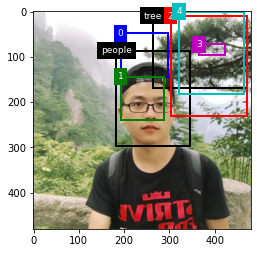

In [20]:
ground_truth = torch.tensor([[0, 0.38, 0.18, 0.72, 0.62],
                         [1, 0.55, 0.02, 0.98, 0.35]])
anchors = torch.tensor([[0.4, 0.1, 0.62, 0.3], [0.40, 0.30, 0.6, 0.5],
                    [0.63, 0.02, 0.98, 0.48], [0.76, 0.15, 0.88, 0.2],
                    [0.67, 0.0, 0.97, 0.38]])

fig = plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['people', 'tree'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

使用上面的`multibox_target`函数，我们可以根据`people`和`tree`的真实边界框，标注这些锚框的分类和偏移量。在这个例子中，背景，`people`和`tree`的类索引分别为`0`，`1`和`2`。下面我们为锚框和真实边界框样本添加一个维度。

In [21]:
labels = multibox_target(anchors.unsqueeze(dim=0), ground_truth.unsqueeze(dim=0))
labels

(tensor([[-0.0000, -0.0000, -0.0000, -0.0000,  2.5000,  0.0000,  2.6531,  3.9423,
          -1.1429, -1.4130,  1.0293, -1.6607, -0.0000, -0.0000, -0.0000, -0.0000,
          -1.8333, -0.1316,  1.8000, -0.7054]]),
 tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
          1., 1.]]),
 tensor([[0, 1, 2, 0, 2]]))

1. 返回的第一个元素包含了为每个锚框标记的四个偏移值。负类锚框的偏移量被标记为`0`。
2. 返回的第二个元素是掩码(`mask`)变量，形状为(批量大小，锚框数的四倍)。掩码变量中的元素与每个锚框的4个偏移量一一对应。由于我们不关心对背景的检测，负类的偏移量不应影响目标函数。通过元素乘法，掩码变量中的零将在计算目标函数之前过滤掉负类偏移量。
3. 第三个元素包含标记的输入锚框的类别。在所有的锚框和真实边界框配对中，锚框$A_{4}$与`tree`的真实边界框的`IoU`是最大的。因此，$A_{4}$的类别被标记为`tree`。取出包含$A_{4}$或`tree`的真实边界框的配对，在剩下的配对中，锚框$A_{1}$和`people`的真实边界框有最大的`IoU`。因此，$A_{1}$的类别被标记为`people`。接下来，我们需要遍历剩下的三个没有标记的锚框$A_{0}, A_{2}$和$A_{3}$。对于$A_{0}$, 与其拥有最大的`IoU`的真实边界框的类别是狗，但`IoU`低于预定的阈值`0.5`, 因此，该类别被标记为背景；对于$A_{2}$, 与其拥有最大的`IoU`的真实边界框的类别是`tree`，`IoU`超过阈值，所以被标记为`tree`；对于$A_{3}$, 与其拥有最大`IoU`的真实边界框是`tree`，但值低于阈值，因此该类别被标记为背景。

训练的时候，每一个锚框是一个训练样本。这样的话，每个锚框要么标注成背景，要么关联上一个真实边缘框。

我们可能会生成大量的锚框，导致大量的负样本。

## 使用非极大值抑制预测边界框

在预测时，我们先为图像生成多个锚框，再为这些锚框一一预测类别和偏移量。一个“预测好的边界框”则根据其中带有预测偏移量的锚框而生成。

下面我们实现`offset_inverse`函数，该函数将锚框和偏移量预测作为输入，并应用

In [22]:
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

当有许多锚框时，可能会输出许多相似的具有明显重叠的预测边界框，都围绕着同一目标。为了简化输出，我们可以使用非极大值抑制(non-maximum suppression, NMS)合并属于同一目标的类似的预测边界框。

以下时非极大值抑制的工作原理。对于一个预测边界框$B$, 目标检测模型会计算每个类别的预测概率。假设最大的预测概率为$p$, 则该概率所对应的类别$B$即为预测的类别。具体来说，我们将$p$称为预测边界框$B$的置信度(confidence)。在同一张图像中，所有预测的非背景边界框都按置信度降序排序，以生成列表$L$。然后，我们通过以下步骤操作排序列表$L$:

1. 从$L$中选取置信度最高的预测边界框$B_{1}$作为基准，然后将所有与$B_{1}$的IoU超过阈值$\epsilon$的非基准预测边界框从$L$中移除。这时，$L$保留了置信度最高的预测边界框，去除了与其太过相似的其他预测边界框。简而言之，那些具有非极大值置信度的边界框被抑制了。

2. 从$L$中选取置信度第二高的预测边界框$B_{2}$作为基准，然后将所有与$B_{2}$的IoU大于$\epsilon$的非基准值预测边界框从$L$中移除。

3. 重复上述过程，直到$L$中的所有预测边界框都曾被用作基准。此时，$L$中任意一对预测边界框的$IoU$都小于阈值$\epsilon$；因此，没有一对边界框过于相似。

4. 输出列表$L$中所有预测边界框。

In [23]:
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []
    while B.numel() > 0:
        i = B[0]  # 拿出最大的那一个
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4), boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)  
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

我们定义以下multibox_detection函数来将非极大值抑制应用于预测边界框。

In [24]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

现在，我们将上述算法应用到一个带有四个锚框的具体示例中。为了简单，假设预测的偏移量都是零，这意味着预测的边界框即是锚框。对于背景、狗和猫，其中的每个类，我们还定义了它的预测概率。

In [25]:
anchors = torch.tensor([[0.3, 0.28, 0.72, 0.92], [0.25, 0.35, 0.62, 0.91],
                        [0.10, 0.2, 0.76, 0.95], [0.55, 0.02, 0.95, 0.38]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                        [0.9, 0.8, 0.7, 0.1],  # people的预测概率
                        [0.1, 0.2, 0.3, 0.9]])  # tree的预测概率

我们可以在图像上绘制这些预测边界框和置信度。

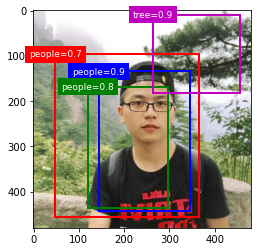

In [26]:
fig = plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['people=0.9', 'people=0.8', 'people=0.7', 'tree=0.9'])

现在我们可以调用multibox_detection函数来执行非极大值抑制，其中阈值设置为0.5。 请注意，我们在示例的张量输入中添加了维度。

我们可以看到返回结果的形状是（批量大小，锚框的数量，6）。 最内层维度中的六个元素提供了同一预测边界框的输出信息。 第一个元素是预测的类索引，从0开始（0代表people，1代表tree），值-1表示背景或在非极大值抑制中被移除了。 第二个元素是预测的边界框的置信度。 其余四个元素分别是预测边界框左上角和右下角的 (𝑥,𝑦) 轴坐标（范围介于0和1之间）。

In [27]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.0000,  0.9000,  0.3000,  0.2800,  0.7200,  0.9200],
         [ 1.0000,  0.9000,  0.5500,  0.0200,  0.9500,  0.3800],
         [-1.0000,  0.8000,  0.2500,  0.3500,  0.6200,  0.9100],
         [-1.0000,  0.7000,  0.1000,  0.2000,  0.7600,  0.9500]]])

删除-1类别（背景）的预测边界框后，我们可以输出由非极大值抑制保存的最终预测边界框。

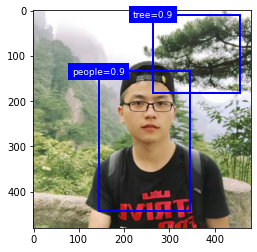

In [29]:
fig = plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('people=', 'tree=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

实践中，在执行非极大值抑制前，我们甚至可以将置信度较低的预测边界框移除，从而减少此算法中的计算量。 我们也可以对非极大值抑制的输出结果进行后处理。例如，只保留置信度更高的结果作为最终输出。